# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [19]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d

# Simulation environment tools
sys.path.append('..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [2]:
# Network size and where are data files stored
networkSize = 30
folderPath = '../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

The following implements some utility functions, not related to main GA

In [3]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [4]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000  19.461347  18.978988  13.148921   9.717353  12.218160   
1        16.493709   0.000000  12.248480  18.882980   8.871050  19.760969   
2         8.749181   9.510101   0.000000   9.718716   8.723837  10.651628   
3        15.071604  19.956029   8.004054   0.000000   8.328253  15.761568   
4        18.321813  14.079354  11.400399  13.441945   0.000000  10.188385   
5        13.129251  14.277677  12.934420  17.542826  10.400436   0.000000   
6        16.718770  15.227973  17.584267  17.581704  11.740838  14.485349   
7         9.773022  18.981200  19.692553  16.201921  18.986956  13.244679   
8        15.595551  10.394889  11.511726  19.491460  13.725072  18.932637   
9        12.956503  15.065482   8.913761   8.955467  10.597430  19.375507   
10       15.091891  10.984494  16.901587  13.808664  15.051596

In [5]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1   25  0.267585    8.229164   48.806264      8.815719       828.185170   
2   14  0.362868   89.459813  -57.312568      3.124788       655.172008   
3   29  0.365775  123.200746  -89.675502      9.507711       888.057880   
4   17  0.441881   -2.849219  127.044026      2.623413       923.581416   
5   13  0.375900  -61.107876   28.681715      8.784226       673.843051   
6   19  0.242082   -7.653437   71.792205      1.374490       899.696824   
7   27  0.131277  -12.408940 -105.797729      3.328028       867.988891   
8    3  0.438245   46.516821   20.163101      5.557819       735.303201   
9    4  0.374963   -4.359159   41.650064      7.049608       818.580036   
10  28  0.262727  -12.071445  -58.239792      6.759532       946.088411   
11   1  0.193070    2.900621 -115.774200      9.126911       642.166928   
12  10  0.433611 

## Create variables

In [6]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)

    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [7]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 2
chooseCustomersRandom = True

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[1, 4, 5, 6, 7, 8, 9, 10, 11],
                   [12, 13, 14, 15, 16, 17]]

    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 13 customer/s
Car 1 must visit 14 customer/s


Car 0 must visit customers with ID: [6, 3, 2, 25, 11, 21, 13, 29, 17, 26, 9, 18, 14]
Car 1 must visit customers with ID: [28, 27, 8, 4, 1, 7, 5, 20, 10, 19, 16, 22, 23, 12]


 ## Setup GA

In [8]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [9]:
# %% the algorithm
# Population TODO create function
n = 250
generations = 100

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.5

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 250 individuals
-- Generation 1 --
  Evaluated 171 individuals
  Min -7022121.018373482
  Max -624405.964254509
  Avg -2339908.8484337707
  Std 1465617.3056033787
Best individual:  [14, 26, 18, 2, 17, 29, 25, 3, 9, 21, 6, 13, 11, -1, 0, 10.0, -1, 0, 10.0, 660, 1, 16, 20, 10, 28, 5, 12, 23, 8, 27, 4, 19, 22, 7, -1, 0, 10.0, -1, 0, 10.0, 701]
Worst individual:  [3, 17, 9, 14, 13, 2, 25, 26, 6, 29, 21, 18, 11, -1, 0, 10.0, -1, 0, 10.0, 163, 5, 28, 27, 23, 8, 7, 4, 20, 19, 10, 1, 16, 12, 22, -1, 0, 10.0, -1, 0, 10.0, 1322]
-- Generation 2 --
  Evaluated 176 individuals
  Min -3935647.717167998
  Max -624001.2507528646
  Avg -1283090.9755588071
  Std 630238.9058128753
Best individual:  [9, 2, 3, 18, 29, 21, 25, 13, 11, 14, 6, 26, 17, -1, 0, 10.0, -1, 0, 10.0, 660, 1, 16, 20, 10, 28, 5, 12, 23, 8, 27, 4, 19, 22, 7, -1, 0, 10.0, -1, 0, 10.0, 701]
Worst individual:  [14, 13, 9, 26, 3, 29, 17, 25, 6, 18, 2, 21, 11, -1, 0, 10.0, 

  Evaluated 182 individuals
  Min -619341.9616932435
  Max -513265.5143118823
  Avg -536213.5622760294
  Std 15407.741705231794
Best individual:  [14, 18, 13, 26, 2, 21, 9, 3, 25, 11, 29, 17, 6, -1, 0, 10.0, -1, 24, 31.430866944695342, 660, 1, 22, 20, 10, 27, 5, 12, 4, 8, 28, 23, 19, 16, 7, -1, 0, 10.0, -1, 0, 10.0, 761.0301655496726]
Worst individual:  [14, 18, 13, 26, 2, 21, 9, 3, 25, 11, 29, 17, 6, -1, 15, 12.358356165398718, -1, 15, 21.915623001177313, 660, 28, 16, 20, 10, 22, 5, 12, 27, 8, 23, 4, 19, 1, 7, -1, 24, 31.997834987339008, -1, 15, 6.593408991069718, 760]
-- Generation 17 --
  Evaluated 161 individuals
  Min -594874.1534558214
  Max -511056.9616076785
  Avg -529198.5060928554
  Std 11456.965707463074
Best individual:  [14, 18, 9, 26, 2, 3, 13, 21, 25, 11, 29, 17, 6, -1, 0, 10.0, -1, 15, 22.90968704171764, 660, 1, 22, 20, 10, 8, 5, 4, 23, 28, 12, 27, 19, 16, 7, -1, 0, 10.0, -1, 15, 6.593408991069718, 760]
Worst individual:  [9, 2, 3, 18, 26, 21, 25, 13, 11, 14, 6, 29, 17,

  Evaluated 170 individuals
  Min -594890.0977159133
  Max -501941.718988861
  Avg -509466.0373623079
  Std 15518.21055230783
Best individual:  [18, 2, 26, 9, 14, 3, 13, 11, 21, 25, 29, 17, 6, -1, 0, 10.0, -1, 15, 9.568617966087924, 660, 1, 22, 20, 10, 27, 12, 8, 4, 5, 28, 23, 19, 16, 7, -1, 0, 10.0, -1, 15, 6.593408991069718, 760]
Worst individual:  [14, 17, 9, 26, 18, 3, 13, 11, 25, 21, 29, 2, 6, -1, 0, 10.0, -1, 15, 22.90968704171764, 660, 1, 22, 20, 10, 8, 19, 4, 23, 28, 12, 16, 5, 27, 7, -1, 0, 10.0, -1, 15, 6.593408991069718, 760]
-- Generation 32 --
  Evaluated 166 individuals
  Min -602921.6283888952
  Max -501758.2332543213
  Avg -507828.4877645462
  Std 13691.987154676835
Best individual:  [14, 2, 9, 26, 18, 3, 13, 11, 21, 25, 29, 17, 6, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 27, 8, 16, 4, 5, 12, 23, 28, 19, 7, -1, 0, 10.0, -1, 0, 10.0, 760]
Worst individual:  [14, 17, 9, 26, 18, 3, 13, 11, 21, 25, 29, 2, 6, -1, 0, 10.0, -1, 15, 22.90968704171764, 660, 1,

  Evaluated 179 individuals
  Min -599192.1321518526
  Max -501167.67110446544
  Avg -507251.95730231534
  Std 15927.771022416262
Best individual:  [14, 2, 18, 26, 13, 3, 9, 11, 21, 25, 29, 6, 17, -1, 15, 47.12597686916059, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 27, 12, 8, 4, 7, 28, 23, 16, 19, 5, -1, 24, 82.80354691921198, -1, 15, 6.593408991069718, 760]
Worst individual:  [17, 2, 9, 26, 18, 3, 13, 11, 21, 25, 29, 6, 14, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 27, 12, 8, 4, 5, 28, 23, 16, 19, 7, -1, 0, 10.0, -1, 15, 6.593408991069718, 760]
-- Generation 47 --
  Evaluated 171 individuals
  Min -627945.8500695084
  Max -501167.67110446544
  Avg -506336.7222877769
  Std 14619.239477231336
Best individual:  [14, 2, 18, 26, 13, 3, 9, 11, 21, 25, 29, 6, 17, -1, 15, 47.12597686916059, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 27, 12, 8, 4, 7, 28, 23, 16, 19, 5, -1, 24, 82.80354691921198, -1, 15, 6.593408991069718, 760]
Worst individual:  [17, 14, 9, 26, 18, 3

  Evaluated 170 individuals
  Min -626679.6005970672
  Max -501091.5476835764
  Avg -506012.1391897834
  Std 14930.44425777606
Best individual:  [2, 14, 13, 26, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 24, 20.641975787295948, 11, 15, 7.741345878800294, 660, 1, 22, 4, 10, 27, 12, 8, 20, 7, 28, 23, 16, 19, 5, -1, 15, 41.99361300380921, -1, 15, 3.292462659450904, 760]
Worst individual:  [17, 14, 26, 13, 18, 3, 9, 11, 21, 25, 29, 6, 2, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 4, 12, 8, 27, 5, 23, 28, 7, 16, 19, -1, 24, 82.80354691921198, -1, 15, 56.23963776062122, 760]
-- Generation 61 --
  Evaluated 185 individuals
  Min -596559.5040256216
  Max -501091.5476835764
  Avg -507998.051326424
  Std 15717.09862705466
Best individual:  [2, 14, 13, 26, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 24, 20.641975787295948, 11, 15, 7.741345878800294, 660, 1, 22, 4, 10, 27, 12, 8, 20, 7, 28, 23, 16, 19, 5, -1, 15, 41.99361300380921, -1, 15, 3.292462659450904, 760]
Worst individual:  [2, 14, 13,

  Evaluated 174 individuals
  Min -628728.5471004557
  Max -500957.4654814364
  Avg -507776.3407947099
  Std 17092.18752102212
Best individual:  [2, 14, 26, 13, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 4, 12, 8, 27, 5, 23, 19, 7, 16, 28, -1, 0, 10.0, 22, 24, 3.5985600793487094, 756.044591978113]
Worst individual:  [17, 14, 13, 26, 18, 3, 9, 11, 21, 25, 29, 6, 2, -1, 15, 36.499353196233784, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 4, 12, 8, 27, 5, 23, 19, 16, 7, 28, -1, 0, 10.0, 22, 24, 3.5985600793487094, 760]
-- Generation 75 --
  Evaluated 180 individuals
  Min -587250.8992212974
  Max -500932.55023009144
  Avg -505858.59060060256
  Std 11506.239301254214
Best individual:  [2, 14, 26, 13, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 4, 12, 8, 27, 5, 16, 19, 7, 23, 28, -1, 0, 10.0, 22, 24, 3.5985600793487094, 753.8816118363252]
Worst individual:  [2, 17, 26, 13, 18, 3, 9, 11, 21, 

  Evaluated 173 individuals
  Min -628627.5805064107
  Max -500590.3782412596
  Avg -507233.32559435087
  Std 16312.029046769447
Best individual:  [2, 14, 26, 13, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 10, 22, 20, 4, 12, 8, 27, 7, 16, 23, 28, 19, 5, -1, 0, 10.0, -1, 15, 12.204051854053546, 753.8816118363252]
Worst individual:  [17, 14, 13, 26, 18, 3, 9, 11, 21, 25, 29, 6, 2, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 22, 20, 10, 4, 8, 12, 27, 5, 23, 7, 19, 16, 28, -1, 24, 21.473694422390107, 22, 24, 3.5985600793487094, 752.6968255267942]
-- Generation 89 --
  Evaluated 177 individuals
  Min -600083.8383812552
  Max -500590.3782412596
  Avg -507248.94732292084
  Std 15801.376146569204
Best individual:  [2, 14, 26, 13, 18, 3, 9, 11, 21, 25, 29, 6, 17, -1, 0, 10.0, 11, 15, 7.741345878800294, 660, 1, 10, 22, 20, 4, 12, 8, 27, 7, 16, 23, 28, 19, 5, -1, 0, 10.0, -1, 15, 12.204051854053546, 753.8816118363252]
Worst individual:  [29, 14, 13, 26, 1

### Obtain best individual

In [10]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

### Theta dynamics

In [11]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [16]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Logarithm of maximum fitness per generation')
figFitness.title.text_font_size = '15pt'
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'
figFitness.axis.axis_label_text_font_size = '15pt'
figFitness.axis.major_label_text_font_size = '15pt'



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Fitness standard deviation per generation')
figFitnessStd.title.text_font_size = '15pt'
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.axis.axis_label_text_font_size = '15pt'
figFitnessStd.axis.major_label_text_font_size = '15pt'

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)

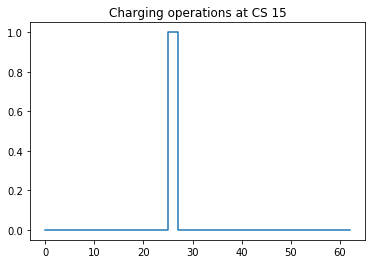

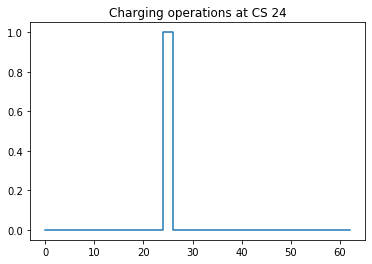

In [20]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(sizing_mode='scale_height',
                   title='Time of reaching/leaving nodes (vehicle '+str(vehicleID)+')')
    figX2 = figure(plot_width=600, plot_height=550,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(35, 85))
    figX3 = figure(plot_width=600, plot_height=550,
                   title='Payload (vehicle '+str(vehicleID)+')')
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Tiempo del día (min)'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Carga (ton)'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k

    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure()
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.show()


In [13]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 59345.407485961914 ms
